In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/alexanderkelso/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [2]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures["1990-01-01":]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [4]:
# Create a series using "Settle" price percentage returnss, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
# YOUR CODE HERE!

yen_futures["returns"] = yen_futures[["Settle"]].pct_change()
yen_futures["returns"] = yen_futures["returns"] * 100
yen_futures.replace(-np.inf, np.nan, inplace=True)
# why do we do this with the -np.inf?
yen_futures.dropna(inplace=True)
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns
Date,,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0,-0.410601
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0,-0.369458
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0,-0.564304
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0,0.151335
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0,-0.469509


### Lagged Returns 

In [5]:
# Create a lagged return using the shift function
# YOUR CODE HERE!
yen_futures['lagged_returns'] = yen_futures['returns'].shift()
# yen_futures.dropna(inplace=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns,lagged_returns
Date,,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829,NaN
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604


### Train Test Split

In [6]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures['2014':'2017']
test = yen_futures['2018':'2019']
display(train.head())

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns,lagged_returns
Date,,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829,NaN
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604


In [7]:
display(test.head())

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,returns,lagged_returns
Date,,,,,,,,,,
2018-01-02,8909.5,8957.5,8898.5,8938.0,26.5,8940.5,96714.0,227884.0,0.297285,0.224871
2018-01-03,8943.0,8947.5,8913.0,8921.0,21.5,8919.0,93498.0,226582.0,-0.240479,0.297285
2018-01-04,8917.0,8920.5,8891.0,8901.0,19.0,8900.0,115434.0,224918.0,-0.213028,-0.240479
2018-01-05,8897.0,8902.0,8854.0,8878.0,31.5,8868.5,133023.0,229326.0,-0.353933,-0.213028
2018-01-08,8870.5,8889.0,8849.5,8872.5,5.5,8874.0,81647.0,237100.0,0.062017,-0.353933


In [8]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
# YOUR CODE HERE!
X_train = train["lagged_returns"]
X_train = X_train.to_frame().dropna()
X_train.head()

,lagged_returns
Date,
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502


In [9]:
y_train = train["returns"]
y_train = y_train.loc['2014-02-19':]
y_train.head()

Date
2014-02-19   -0.020460
2014-02-20    0.020465
2014-02-21   -0.204604
2014-02-24    0.020502
2014-02-25    0.327970
Name: returns, dtype: float64

In [10]:
X_test = test["lagged_returns"].to_frame()
X_test.head()

,lagged_returns
Date,
2018-01-02,0.224871
2018-01-03,0.297285
2018-01-04,-0.240479
2018-01-05,-0.213028
2018-01-08,-0.353933


In [11]:
y_test = test["returns"]
y_test.head()

Date
2018-01-02    0.297285
2018-01-03   -0.240479
2018-01-04   -0.213028
2018-01-05   -0.353933
2018-01-08    0.062017
Name: returns, dtype: float64

# Linear Regression Model

In [12]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
# YOUR CODE HERE!
model = LinearRegression()
model.fit(X_train, y_train)
model

LinearRegression()

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [13]:
# Make a prediction of "y" values using just the test dataset
# YOUR CODE HERE!
ypredictions = model.predict(X_test)
ypredictions.size

448

In [14]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
# YOUR CODE HERE!
results = y_test.to_frame()
results.head()

,returns
Date,
2018-01-02,0.297285
2018-01-03,-0.240479
2018-01-04,-0.213028
2018-01-05,-0.353933
2018-01-08,0.062017


In [15]:
results.size

448

In [16]:
results['predictions'] = ypredictions
results.head()

,returns,predictions
Date,,
2018-01-02,0.297285,-0.008621
2018-01-03,-0.240479,-0.008885
2018-01-04,-0.213028,-0.006923
2018-01-05,-0.353933,-0.007024
2018-01-08,0.062017,-0.006509


In [17]:
results.iloc[19]

returns        0.152116
predictions   -0.006891
Name: 2018-01-30 00:00:00, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc04887aa50>,
      dtype=object)

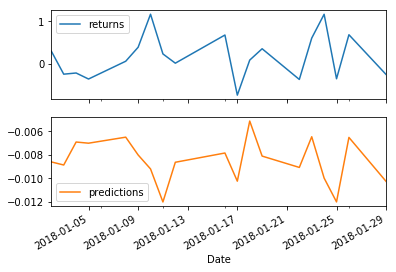

In [18]:
# Plot the first 20 predictions vs the true values
# YOUR CODE HERE!
first_20_plot = results[:19].plot(subplots=True)
first_20_plot

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [19]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
# YOUR CODE HERE!
mse = mean_squared_error(
    results["returns"],
    results["predictions"]
)

print (f"The mean standard error is: {round(mse,2)}")

The mean standard error is: 0.17


In [20]:
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
# YOUR CODE HERE!

oos_rmse = np.sqrt(mse)
print(f"The out of sample root mean squared error (RMSE) is: {round(oos_rmse,2)}")

The out of sample root mean squared error (RMSE) is: 0.42


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [33]:
# Construct a dataframe using just the "y" training data:
# YOUR CODE HERE!
sample_results = y_train.to_frame()
sample_results.head()

,returns
Date,
2014-02-19,-0.020460
2014-02-20,0.020465
2014-02-21,-0.204604
2014-02-24,0.020502
2014-02-25,0.327970


In [22]:
# Add a column of "in-sample" predictions to that dataframe:  
# YOUR CODE HERE!

sample_results["in sample predictions"] = model.predict(X_train)
sample_results.head()

,returns,in sample predictions
Date,,
2014-02-19,-0.020460,-0.006240
2014-02-20,0.020465,-0.007726
2014-02-21,-0.204604,-0.007875
2014-02-24,0.020502,-0.007054
2014-02-25,0.327970,-0.007876


In [31]:
# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!

sample_mse = mean_squared_error(
    sample_results["returns"],
    sample_results["in sample predictions"]
)

print(f"the sample mse is: {round(sample_mse,2)}")

the sample mse is: 0.36


In [36]:
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
# YOUR CODE HERE!
insample_rmse = np.sqrt(sample_mse)
print(f"the in-sample root mean squared error (RMSE) is: {round(insample_rmse,3)}")

the in-sample root mean squared error (RMSE) is: 0.596


# Conclusions

** Mean Squared Errors: **
 * Out of sample performance: 0.42
 * In-Sample Performance: 0.596

This kind of indicates that for some reason, the model works better for in-sample data than out-of-sample data. I.e. the testing data.

THis is kind of weird. Usually you'd expect better performance for the in-testing data.